# Лабораторная работа №1 по вычислительной математике
## Cравнение абсолютных погрешностей методов численного взятия производных
### Выполнил Филиппенко Павел -- студент группы Б01-009

In [505]:
import numpy as np
import matplotlib.pyplot as plt
import sympy as sp
import math

#### ErrMeth -- класс, отвечающий за визуализацию зависимости ошибки от шага для конкретно выбранного численного метода.

_Поля класса:_
- mthd_name -- имя используемого численного метода
- mthd_fun -- функция численного метода

_Методы класса:_
- GetErr() -- функция возвращает значение абсолютной погрешности для заданной функции function_sketch
- PlotErr() -- выводит график зависимости значения абсолютной погрешности от шага h

___
Заметим, что в методы GetErr() и PlotErr() в качестве аргумента передается не настоящая функция, а символьный эскиз функции, полученный с помощью модуля sympy (то, есть если вызвать такую функцию и передать туда аргумент, ничего не произойдет). Подробнее читайте про модуль sympy.

In [506]:
class ErrMethod:

    h_arr = np.array([2/2**n for n in range(1,21)])

    def __init__(self, method_name: str, method_func):
        self.mthd_name = method_name # название используемого численного метода 
        self.mthd_func = method_func # численный метод


    def GetErr(self, point, h, function_sketch: sp.core.power.Pow):
        x = sp.Symbol('x')

        #---------------------------------------------------
        '''Сделаем реальную функцию, по заданному эскизу'''
        func = sp.lambdify(x, function_sketch)
        diff_func = sp.lambdify(x, sp.diff(function_sketch))
        #---------------------------------------------------

        try:
            res = abs(diff_func(point) - self.mthd_func(func, point, h))
        except ZeroDivisionError:
            print('[!] ZeroDivisionError.\n'
                  'Probably there is a bad argument for function ' + str(function_sketch) + ' '
                  'Try to enother argument x'
                  )
            return None

        return res


    def PlotErr(self, point, function_sketch: sp.core.power.Pow):
        err_m = np.array([])
        for h in self.h_arr:
            err = self.GetErr(point, h, function_sketch)
            if err == None: return None

            err_m = np.append(err_m, err)

        return plt.loglog(self.h_arr, err_m, marker='s', alpha=0.75, lw=1.5, ls='-', label=self.mthd_name)

#### GraphErr -- класс, отвечающий за визуализацию сравнения зависимостей значений абсолютной погрешности от шага h различных численных методов для выбранной функции функции function.

_Поля класа:_
- function -- представляет собой кортеж из имени выбранной функции и самой функции (f_name, f)
- err_method_map -- массив методов численного расчета

_Методы класса:_
- Plot() -- метод выводит на один рисунок все графики зависимости значения абсолютной ошибки от шага h для всех численных методов в массиве err_method_map
- BestMeth() -- метод определяет наилучший численный метод (дающий наименьшую погрешность) из представленного массива. 

In [507]:
class GraphErr:

    def __init__(self, function: tuple, err_method_map: np.ndarray):
        self.function_name = function[0] # название аналитической функции
        self.function = function[1]      # аналитическая функция
        self.mthd_map = err_method_map   # набор численных методов

    def Plot(self, point):
        for meth in self.mthd_map:
            res = meth.PlotErr(point, self.function)
            if res == None: return None

        plt.minorticks_on()
        plt.grid(which = 'major', color = 'black', linewidth = 1, linestyle = '-', alpha = 0.75)
        plt.grid(which = 'minor', color = 'grey', linewidth = 1, linestyle = '--', alpha = 0.5)

        plt.legend()
        plt.title(self.function_name + r'   $(x_0 = %0.2f)$' %point)
        plt.xlabel('h')
        plt.ylabel(r'$\Delta f$')

        return 0

    def BestMeth(self):
        pass

##### Зададим массив исследуемых аналитических функций:

$$f_1 = \sin x^2$$
$$f_2 = \cos \sin x$$   
$$f_3 = e^{\sin \cos x}$$   
$$f_4 = \ln (x + 3)$$   
$$f_5 = \sqrt{x + 3}$$   

___
Заметим, что элементы в словаре не являются реальными функцими. Данные функции являются символьными эскизами реальных функций.

In [508]:
x = sp.Symbol('x')
func_sketch_map = {"sin(x^2)"         : sp.sin(x ** 2), 
                   "cos(sin(x))"      : sp.cos(sp.sin(x)), 
                   "exp(sin(cos(x)))" : sp.exp(sp.sin(sp.cos(x))), 
                   "ln(x + 3)"        : sp.log(x + 3),
                   "(x + 3)^(0,5)"    : (x + 3) ** (1/2)}

##### Зададим методы численного расчета первых производных функций:

$$\frac{f(x + h) - f(x)}{h}$$   
$$\frac{f(x) - f(x - h)}{h}$$   
$$\frac{f(x + h) - f(x - h)}{2h}$$   
$$\frac{4}{3} \frac{f(x + h) - f(x - h)}{2h} - \frac{1}{3} \frac{f(x + 2h) - f(x - 2h)}{4h}$$   
$$\frac{3}{2} \frac{f(x + h) - f(x - h)}{2h} - \frac{3}{5} \frac{f(x + 2h) - f(x - 2h)}{4h} - \frac{1}{10} \frac{f(x + 3h) - f(x - 3h)}{6h}$$

Создадим массив объектов ErrMethod (для каждой функции численного расчета).

In [509]:
def meth1(f, x, h):
    return (f(x + h) - f(x)) / h

def meth2(f, x, h):
    return (f(x) - f(x - h)) / h

def meth3(f, x, h):
    return (f(x + h) - f(x - h)) / (2*h)

def meth4(f, x, h):
    return (4/3) * (f(x + h) - f(x - h)) / (2*h) - (1/3) * (f(x + 2*h) - f(x - 2*h)) / (4*h)

def meth5(f, x, h):
    return (3/2) * (f(x + h) - f(x - h)) / (2*h) - (3/5) * (f(x + 2*h) - f(x - 2*h)) / (4*h) + (1/10) * (f(x + 3*h) - f(x - 3*h)) / (6*h)

mthd_map = np.array([
    ErrMethod('meth1', meth1), 
    ErrMethod('meth2', meth2), 
    ErrMethod('meth3', meth3),
    ErrMethod('meth4', meth4),
    ErrMethod('meth5', meth5)
])

In [510]:
def main():

    x0 = 9.27

    for key in func_sketch_map.keys():
        figure, _ = plt.subplots()
        
        graph_obj = GraphErr((key, func_sketch_map[key]), mthd_map)
        result = graph_obj.Plot(x0)

        if result != None: figure.savefig("images/" + str(key) + ".pdf")

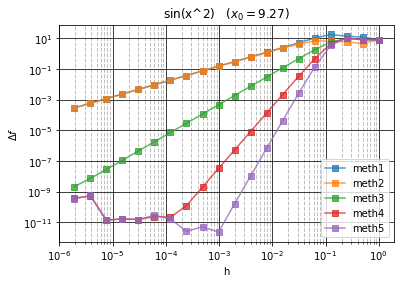

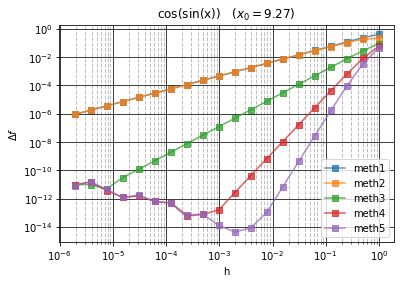

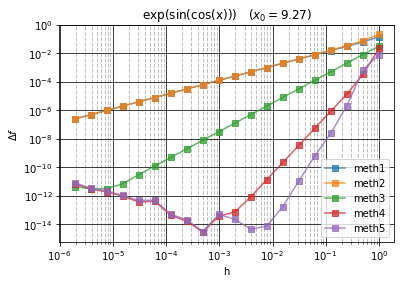

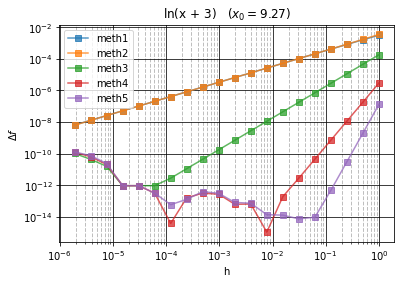

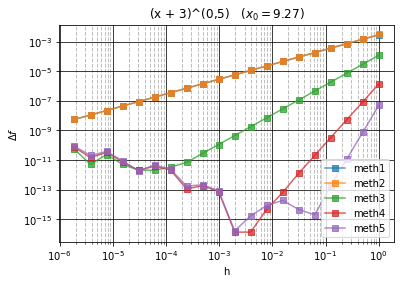

In [511]:
if __name__ == '__main__':
    main()